### Phase 1: Extracting Data from HTML

In [1]:
from pprint import pprint
import time
import json
import os
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
# script to scrape rentberry.com
def scrape_rentberry(city_code, country_code):
    if country_code:
        url = f"https://rentberry.com/{country_code}/apartments/s/{city_code}"
    else:
        url = f"https://rentberry.com/apartments/s/{city_code}"

    # Initialize WebDriver
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)

    # Scroll down to load more listings (if necessary)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  # Adjust the sleep time as needed

    # Parse the HTML content
    html_content = driver.page_source

    # Ensure output directory exists
    output_dir = "htmls"
    os.makedirs(output_dir, exist_ok=True)

    # save the page html content
    with open(os.path.join("htmls", f"{city_code}.html"), "w") as f:
        f.write(html_content)

    driver.quit()


In [3]:
# list of cities to scrape

usa_cities = [
    "austin-tx",
    "buffalo-ny",
    "dallas-tx",
    "jersey-city-nj",
    "las-vegas-nv",
    "miami-fl",
    "orlando-fl",
]
canada_cities = ["ottawa-on-canada", "vancouver-bc-canada", "toronto-on-canada"]
au_cities = [
    "brisbane-qld-australia",
    "melbourne-vic-australia",
    "sydney-nsw-australia",
    "perth-wa-australia",
]
japan_cities = ["tokyo-japan"]
uk_cities = ["birmingham-uk", "glasgow-uk"]
europe_cities = ["amsterdam-netherlands"]
german_cities = ["frankfurt-germany", "munich-germany"]

cities_dict = {city: None for city in usa_cities}
cities_dict.update({city: "ca" for city in canada_cities})
cities_dict.update({city: "au" for city in au_cities})
cities_dict.update({city: "jp" for city in japan_cities})
cities_dict.update({city: "gb" for city in uk_cities})
cities_dict.update({city: "nl" for city in europe_cities})
cities_dict.update({city: "de" for city in german_cities})

pprint(cities_dict)

# # Save html file for each city

for city_code, country_code in cities_dict.items():
    scrape_rentberry(city_code, country_code)

{'amsterdam-netherlands': 'nl',
 'austin-tx': None,
 'birmingham-uk': 'gb',
 'brisbane-qld-australia': 'au',
 'buffalo-ny': None,
 'dallas-tx': None,
 'frankfurt-germany': 'de',
 'glasgow-uk': 'gb',
 'jersey-city-nj': None,
 'las-vegas-nv': None,
 'melbourne-vic-australia': 'au',
 'miami-fl': None,
 'munich-germany': 'de',
 'orlando-fl': None,
 'ottawa-on-canada': 'ca',
 'perth-wa-australia': 'au',
 'sydney-nsw-australia': 'au',
 'tokyo-japan': 'jp',
 'toronto-on-canada': 'ca',
 'vancouver-bc-canada': 'ca'}


In [4]:
with open(r"htmls\austin-tx.html", "r") as f:
    html_content = f.read()

In [51]:
# pprint(html_content)

In [35]:
# extract_data_from_html 

from bs4 import BeautifulSoup
import json

def extract_data_from_html(html_content):
    soup = BeautifulSoup(html_content, "html.parser")

    # Find all script tags
    scripts = soup.find_all("script")

    for script in scripts:
        script_content = script.string

        # Ensure script content is not None
        if script_content and "properties" in script_content:
            # Find the position where the JSON data starts
            idx = script_content.find('"properties":{')
            if idx == -1:
                continue

            # Extract the JSON data by balancing braces
            json_start = idx + len('"properties":')
            substring = script_content[json_start:]

            # Initialize brace counter
            braces = 0
            for i, c in enumerate(substring):
                if c == "{":
                    braces += 1
                elif c == "}":
                    braces -= 1

                # Check if all braces are closed
                if braces == 0:
                    json_text = substring[: i + 1]
                    break
            else:
                continue

            # Construct the full JSON string
            json_text = "{" + '"properties":' + json_text + "}"

            # Replace JavaScript-specific values
            json_text = json_text.replace("undefined", "null")

            try:
                # Parse the JSON data
                data = json.loads(json_text)

                # Access the required information
                apartments = data["properties"]["apartments"]
                result = []
                for apartment in apartments:
                    apartment_data = {
                        "price": apartment.get("price"),
                        "number_of_bedrooms": apartment.get("bedrooms"),
                        "number_of_bathrooms": apartment.get("baths"),
                        "space": apartment.get("space"),
                        "apartment_type": apartment.get("type"),
                        "latitude": apartment.get("latitude"),
                        "longitude": apartment.get("longitude"),
                        "currency": apartment.get("currency"),
                        "listed_at": apartment.get("listedAt"),
                        "address": apartment.get("address").get("formattedAddress"),
                        "city": apartment.get("address", {}).get("city"),
                        "deposit": apartment.get("deposit"),
                    }
                    
                    # Amenities extraction
                    amenities = set(apartment.get("amenities", []))
                    apartment_data.update({
                        "washer_dryer": "yes" if "Washer" in amenities or "Dryer" in amenities else "no",
                        "ac": "yes" if "AC" in amenities else "no",
                        "airconditioning": "yes" if "airconditioning" in amenities else "no",
                        "parking": "yes" if "Parking" in amenities else "no",
                        "fireplace": "yes" if "Fireplace" in amenities else "no",
                        "dishwasher": "yes" if "Dishwasher" in amenities else "no",
                        "hardwood_floors": "yes" if "Hardwood Floors" in amenities else "no",
                        "roofdeck": "yes" if "Roofdeck" in amenities else "no",
                        "storage": "yes" if "Storage" in amenities else "no",
                        "pets_allowed": "yes" if "Pets Allowed" in amenities else "no"
                    })
                    
                    result.append(apartment_data)

                return result  # Return the data if needed

            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                pass
    return None


In [36]:
# combine all html files into one list

html_path = "htmls"

all_cities = []
for file in os.listdir(html_path):
    with open(os.path.join(html_path, file), "r") as f:
        html_content = f.read()
        all_cities.extend(extract_data_from_html(html_content))

In [37]:
# convert to dataframe

import pandas as pd
df = pd.DataFrame(all_cities)

df

,price,number_of_bedrooms,number_of_bathrooms,space,apartment_type,latitude,longitude,currency,listed_at,address,...,deposit,washer_dryer,ac,parking,fireplace,dishwasher,hardwood_floors,roofdeck,storage,pets_allowed
0,3652.00,3,2.0,48.0,apartment,52.392726,4.882539,EUR,2024-11-01T05:11:19+00:00,"Memeleiland 145, 1014 ZL Amsterdam, Netherlands",...,NaN,no,no,no,no,yes,no,no,no,no
1,4400.00,2,1.0,60.0,apartment,52.360954,4.883745,EUR,2024-11-01T05:04:47+00:00,"Pieter Cornelisz. Hooftstraat 13, 1071 BL Amst...",...,4400.0,no,no,no,no,yes,no,no,no,no
2,4450.00,2,1.0,65.0,apartment,52.367151,4.889566,EUR,2024-11-01T05:09:04+00:00,"Singel 470, 1017 AV Amsterdam, Netherlands",...,4450.0,no,no,no,no,yes,no,no,no,no
3,3308.00,0,1.0,30.0,apartment,52.341914,4.800798,EUR,2024-11-01T05:02:27+00:00,"Ditlaar 55, 1066 EE Amsterdam, Netherlands",...,1000.0,no,no,yes,no,yes,no,no,no,no
4,4000.00,1,1.0,48.0,apartment,52.396122,4.904024,EUR,2024-11-01T05:03:18+00:00,"Ridderspoorweg 140, 1032 LL Amsterdam, Netherl...",...,NaN,no,no,no,no,yes,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,10598.21,2,2.0,NaN,apartment,49.279648,-123.125755,CAD,2024-11-01T00:20:29+00:00,"Yaletown, Vancouver, BC V6Z 2Y7, Canada",...,NaN,yes,no,no,no,no,no,no,no,no
436,2125.29,2,1.0,58.0,apartment,49.259793,-123.135471,CAD,2024-11-01T05:18:19+00:00,"1371 West 13th Avenue, Vancouver, BC, Canada",...,NaN,no,no,no,no,no,no,no,no,no
437,800.00,5,2.0,150.0,room,49.216344,-123.140684,CAD,2024-11-01T06:38:04+00:00,"7650 Granville Street, Vancouver, BC, Canada",...,NaN,no,no,no,no,no,no,no,no,no
438,1000.00,7,4.0,150.0,room,49.219018,-123.097477,CAD,2024-11-01T06:37:44+00:00,"East 56th Avenue, Vancouver, BC, Canada",...,NaN,no,no,no,no,no,no,no,no,no


In [43]:
# Create a function to extract the country from an address
import re
def extract_country_from_address(address):
    # Regex pattern to capture the word after the last comma
    country_pattern = r",\s*([A-Za-z\s]+)$"
    
    # Search for the pattern in the address
    country_match = re.search(country_pattern, address)
    
    # Return the matched country, or None if not found
    return country_match.group(1).strip() if country_match else None


In [46]:
# Apply the function to each address in the 'address' column
df['country'] = df['address'].apply(extract_country_from_address)
df

,price,number_of_bedrooms,number_of_bathrooms,space,apartment_type,latitude,longitude,currency,listed_at,address,...,washer_dryer,ac,parking,fireplace,dishwasher,hardwood_floors,roofdeck,storage,pets_allowed,country
0,3652.00,3,2.0,48.0,apartment,52.392726,4.882539,EUR,2024-11-01T05:11:19+00:00,"Memeleiland 145, 1014 ZL Amsterdam, Netherlands",...,no,no,no,no,yes,no,no,no,no,Netherlands
1,4400.00,2,1.0,60.0,apartment,52.360954,4.883745,EUR,2024-11-01T05:04:47+00:00,"Pieter Cornelisz. Hooftstraat 13, 1071 BL Amst...",...,no,no,no,no,yes,no,no,no,no,Netherlands
2,4450.00,2,1.0,65.0,apartment,52.367151,4.889566,EUR,2024-11-01T05:09:04+00:00,"Singel 470, 1017 AV Amsterdam, Netherlands",...,no,no,no,no,yes,no,no,no,no,Netherlands
3,3308.00,0,1.0,30.0,apartment,52.341914,4.800798,EUR,2024-11-01T05:02:27+00:00,"Ditlaar 55, 1066 EE Amsterdam, Netherlands",...,no,no,yes,no,yes,no,no,no,no,Netherlands
4,4000.00,1,1.0,48.0,apartment,52.396122,4.904024,EUR,2024-11-01T05:03:18+00:00,"Ridderspoorweg 140, 1032 LL Amsterdam, Netherl...",...,no,no,no,no,yes,no,no,no,no,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,10598.21,2,2.0,NaN,apartment,49.279648,-123.125755,CAD,2024-11-01T00:20:29+00:00,"Yaletown, Vancouver, BC V6Z 2Y7, Canada",...,yes,no,no,no,no,no,no,no,no,Canada
436,2125.29,2,1.0,58.0,apartment,49.259793,-123.135471,CAD,2024-11-01T05:18:19+00:00,"1371 West 13th Avenue, Vancouver, BC, Canada",...,no,no,no,no,no,no,no,no,no,Canada
437,800.00,5,2.0,150.0,room,49.216344,-123.140684,CAD,2024-11-01T06:38:04+00:00,"7650 Granville Street, Vancouver, BC, Canada",...,no,no,no,no,no,no,no,no,no,Canada
438,1000.00,7,4.0,150.0,room,49.219018,-123.097477,CAD,2024-11-01T06:37:44+00:00,"East 56th Avenue, Vancouver, BC, Canada",...,no,no,no,no,no,no,no,no,no,Canada


In [47]:
df["currency"].unique()

array(['EUR', 'USD', 'GBP', 'AUD', 'CAD', 'JPY'], dtype=object)

In [48]:
# Return the price in INR

def convert_to_inr(price_str):
    # Remove non-numeric characters
    price = float("".join(filter(str.isdigit, price_str)))
    currency = price_str.split()[-1]
    conversion_rates = {
        "USD": 83.12,
        "CAD": 60.34,
        "AUD": 55.26,
        "JPY": 0.55,
        "EUR": 90.73,
        "CHF": 95.73,
        "KWD": 270.04,
        "AED": 22.63,
        "CAD": 60.34,
        "AUD": 55.26,
        "GBP": 101.42
    }
    inr_price = price * conversion_rates.get(
        currency, 1
    )  # Default to 1 if no currency match
    return round(inr_price)

In [49]:
# calculate the full currency
df["full_currency"] = df["price"].astype(str) + " " + df["currency"]

df.head()

,price,number_of_bedrooms,number_of_bathrooms,space,apartment_type,latitude,longitude,currency,listed_at,address,...,ac,parking,fireplace,dishwasher,hardwood_floors,roofdeck,storage,pets_allowed,country,full_currency
0,3652.0,3,2.0,48.0,apartment,52.392726,4.882539,EUR,2024-11-01T05:11:19+00:00,"Memeleiland 145, 1014 ZL Amsterdam, Netherlands",...,no,no,no,yes,no,no,no,no,Netherlands,3652.0 EUR
1,4400.0,2,1.0,60.0,apartment,52.360954,4.883745,EUR,2024-11-01T05:04:47+00:00,"Pieter Cornelisz. Hooftstraat 13, 1071 BL Amst...",...,no,no,no,yes,no,no,no,no,Netherlands,4400.0 EUR
2,4450.0,2,1.0,65.0,apartment,52.367151,4.889566,EUR,2024-11-01T05:09:04+00:00,"Singel 470, 1017 AV Amsterdam, Netherlands",...,no,no,no,yes,no,no,no,no,Netherlands,4450.0 EUR
3,3308.0,0,1.0,30.0,apartment,52.341914,4.800798,EUR,2024-11-01T05:02:27+00:00,"Ditlaar 55, 1066 EE Amsterdam, Netherlands",...,no,yes,no,yes,no,no,no,no,Netherlands,3308.0 EUR
4,4000.0,1,1.0,48.0,apartment,52.396122,4.904024,EUR,2024-11-01T05:03:18+00:00,"Ridderspoorweg 140, 1032 LL Amsterdam, Netherl...",...,no,no,no,yes,no,no,no,no,Netherlands,4000.0 EUR


In [50]:
# calculate price in INR
df.loc[:, "price"] = df["full_currency"].apply(lambda x: convert_to_inr(x))
df.drop(columns=["full_currency", "currency"], inplace=True)
df.head()

,price,number_of_bedrooms,number_of_bathrooms,space,apartment_type,latitude,longitude,listed_at,address,city,...,washer_dryer,ac,parking,fireplace,dishwasher,hardwood_floors,roofdeck,storage,pets_allowed,country
0,3313460.0,3,2.0,48.0,apartment,52.392726,4.882539,2024-11-01T05:11:19+00:00,"Memeleiland 145, 1014 ZL Amsterdam, Netherlands",Amsterdam,...,no,no,no,no,yes,no,no,no,no,Netherlands
1,3992120.0,2,1.0,60.0,apartment,52.360954,4.883745,2024-11-01T05:04:47+00:00,"Pieter Cornelisz. Hooftstraat 13, 1071 BL Amst...",Amsterdam,...,no,no,no,no,yes,no,no,no,no,Netherlands
2,4037485.0,2,1.0,65.0,apartment,52.367151,4.889566,2024-11-01T05:09:04+00:00,"Singel 470, 1017 AV Amsterdam, Netherlands",Amsterdam,...,no,no,no,no,yes,no,no,no,no,Netherlands
3,3001348.0,0,1.0,30.0,apartment,52.341914,4.800798,2024-11-01T05:02:27+00:00,"Ditlaar 55, 1066 EE Amsterdam, Netherlands",Amsterdam,...,no,no,yes,no,yes,no,no,no,no,Netherlands
4,3629200.0,1,1.0,48.0,apartment,52.396122,4.904024,2024-11-01T05:03:18+00:00,"Ridderspoorweg 140, 1032 LL Amsterdam, Netherl...",Amsterdam,...,no,no,no,no,yes,no,no,no,no,Netherlands


In [52]:
# save to csv
df.to_csv("rent.csv", index=False)

### Phase 2 SQL

### Phase 3: EDA

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium

In [53]:
df.head()

,price,number_of_bedrooms,number_of_bathrooms,space,apartment_type,latitude,longitude,listed_at,address,city,...,washer_dryer,ac,parking,fireplace,dishwasher,hardwood_floors,roofdeck,storage,pets_allowed,country
0,3313460.0,3,2.0,48.0,apartment,52.392726,4.882539,2024-11-01T05:11:19+00:00,"Memeleiland 145, 1014 ZL Amsterdam, Netherlands",Amsterdam,...,no,no,no,no,yes,no,no,no,no,Netherlands
1,3992120.0,2,1.0,60.0,apartment,52.360954,4.883745,2024-11-01T05:04:47+00:00,"Pieter Cornelisz. Hooftstraat 13, 1071 BL Amst...",Amsterdam,...,no,no,no,no,yes,no,no,no,no,Netherlands
2,4037485.0,2,1.0,65.0,apartment,52.367151,4.889566,2024-11-01T05:09:04+00:00,"Singel 470, 1017 AV Amsterdam, Netherlands",Amsterdam,...,no,no,no,no,yes,no,no,no,no,Netherlands
3,3001348.0,0,1.0,30.0,apartment,52.341914,4.800798,2024-11-01T05:02:27+00:00,"Ditlaar 55, 1066 EE Amsterdam, Netherlands",Amsterdam,...,no,no,yes,no,yes,no,no,no,no,Netherlands
4,3629200.0,1,1.0,48.0,apartment,52.396122,4.904024,2024-11-01T05:03:18+00:00,"Ridderspoorweg 140, 1032 LL Amsterdam, Netherl...",Amsterdam,...,no,no,no,no,yes,no,no,no,no,Netherlands


In [54]:
df.shape

(440, 21)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                440 non-null    float64
 1   number_of_bedrooms   440 non-null    int64  
 2   number_of_bathrooms  440 non-null    float64
 3   space                295 non-null    float64
 4   apartment_type       440 non-null    object 
 5   latitude             440 non-null    float64
 6   longitude            440 non-null    float64
 7   listed_at            440 non-null    object 
 8   address              440 non-null    object 
 9   city                 420 non-null    object 
 10  deposit              82 non-null     float64
 11  washer_dryer         440 non-null    object 
 12  ac                   440 non-null    object 
 13  parking              440 non-null    object 
 14  fireplace            440 non-null    object 
 15  dishwasher           440 non-null    obj

In [56]:
df.describe()

,price,number_of_bedrooms,number_of_bathrooms,space,latitude,longitude,deposit
count,4.400000e+02,440.000000,440.000000,295.000000,440.000000,440.000000,82.000000
mean,2.337338e+07,2.325000,1.590909,993.362712,26.960152,-8.935134,2341.268293
std,4.870820e+07,1.451199,0.950798,1435.189852,31.029340,95.790325,1773.383417
min,3.960000e+05,0.000000,0.000000,1.000000,-38.176502,-123.140684,100.000000
25%,1.521300e+06,1.000000,1.000000,91.500000,27.759481,-80.571058,1211.000000
50%,2.909200e+06,2.000000,1.000000,707.000000,38.497605,-39.188379,2400.000000
75%,2.560792e+07,3.000000,2.000000,1320.000000,48.443620,37.663382,2994.750000
max,4.803130e+08,8.000000,7.000000,14434.000000,55.903755,153.373505,13000.000000


In [57]:
df.describe(include=['object', 'category'])

,apartment_type,listed_at,address,city,washer_dryer,ac,parking,fireplace,dishwasher,hardwood_floors,roofdeck,storage,pets_allowed,country
count,440,440,440,420,440,440,440,440,440,440,440,440,440,310
unique,6,437,405,82,2,1,2,2,2,2,1,2,1,13
top,apartment,2024-11-01T05:04:01+00:00,"Buffalo, NY",Vancouver,no,no,no,no,no,no,no,no,no,Australia
freq,196,2,6,22,386,440,322,420,275,423,440,426,440,86


In [58]:
# Check for missing values
df.isnull().sum()



price                    0
number_of_bedrooms       0
number_of_bathrooms      0
space                  145
apartment_type           0
latitude                 0
longitude                0
listed_at                0
address                  0
city                    20
deposit                358
washer_dryer             0
ac                       0
parking                  0
fireplace                0
dishwasher               0
hardwood_floors          0
roofdeck                 0
storage                  0
pets_allowed             0
country                130
dtype: int64

In [63]:
# Convert 'listed_at' to datetime
df['listed_at'] = pd.to_datetime(df['listed_at'], errors='coerce')

# Convert numerical columns from object to float/int if necessary
numerical_cols = ['price', 'number_of_bedrooms', 'number_of_bathrooms', 'space', 'latitude', 'longitude', 'deposit']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Verify changes
print(df.dtypes)

price                              float64
number_of_bedrooms                   int64
number_of_bathrooms                float64
space                              float64
apartment_type                      object
latitude                           float64
longitude                          float64
listed_at              datetime64[ns, UTC]
address                             object
city                                object
deposit                            float64
washer_dryer                        object
ac                                  object
parking                             object
fireplace                           object
dishwasher                          object
hardwood_floors                     object
roofdeck                            object
storage                             object
pets_allowed                        object
country                             object
dtype: object


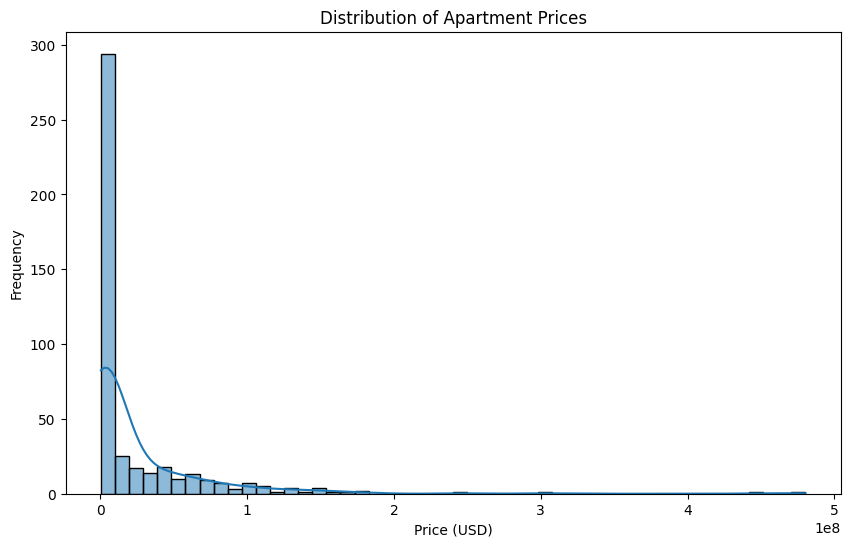

In [64]:
# Distribution of Prices
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Apartment Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()




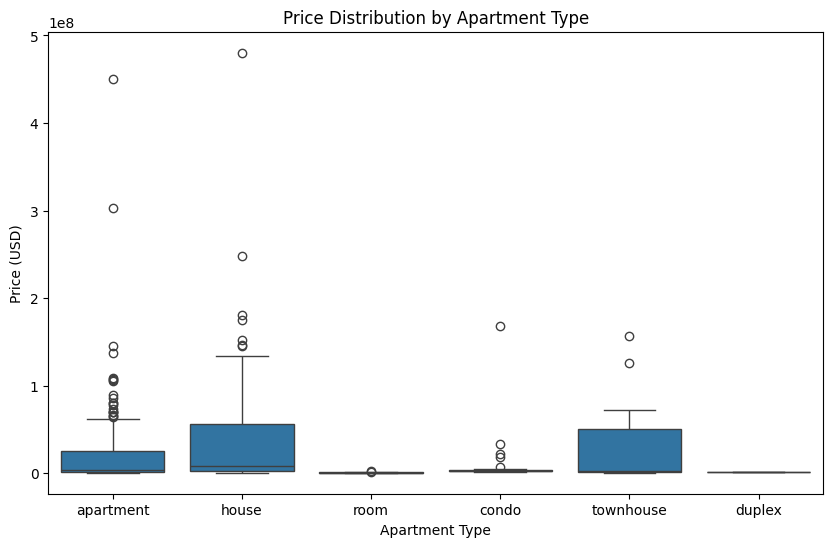

In [65]:
# Boxplot for Price by Apartment Type
plt.figure(figsize=(10,6))
sns.boxplot(x='apartment_type', y='price', data=df)
plt.title('Price Distribution by Apartment Type')
plt.xlabel('Apartment Type')
plt.ylabel('Price (USD)')
plt.show()



C:\Users\ve797\AppData\Local\Temp\ipykernel_36364\766803954.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='number_of_bedrooms', y='price', data=avg_price_bedrooms, palette='viridis')


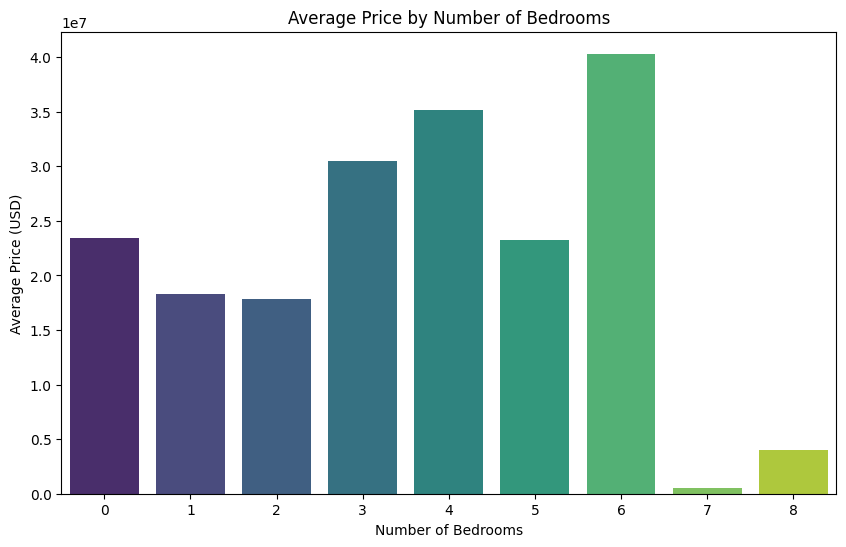

In [66]:
# Average Price by Number of Bedrooms
avg_price_bedrooms = df.groupby('number_of_bedrooms')['price'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='number_of_bedrooms', y='price', data=avg_price_bedrooms, palette='viridis')
plt.title('Average Price by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Price (USD)')
plt.show()

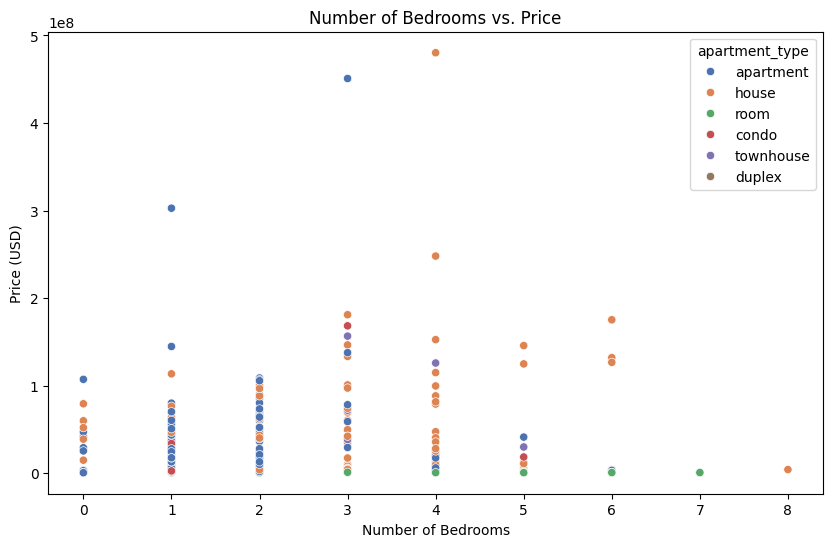

In [67]:
# Scatter Plot: Bedrooms vs. Price
plt.figure(figsize=(10,6))
sns.scatterplot(x='number_of_bedrooms', y='price', hue='apartment_type', data=df, palette='deep')
plt.title('Number of Bedrooms vs. Price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (USD)')
plt.show()



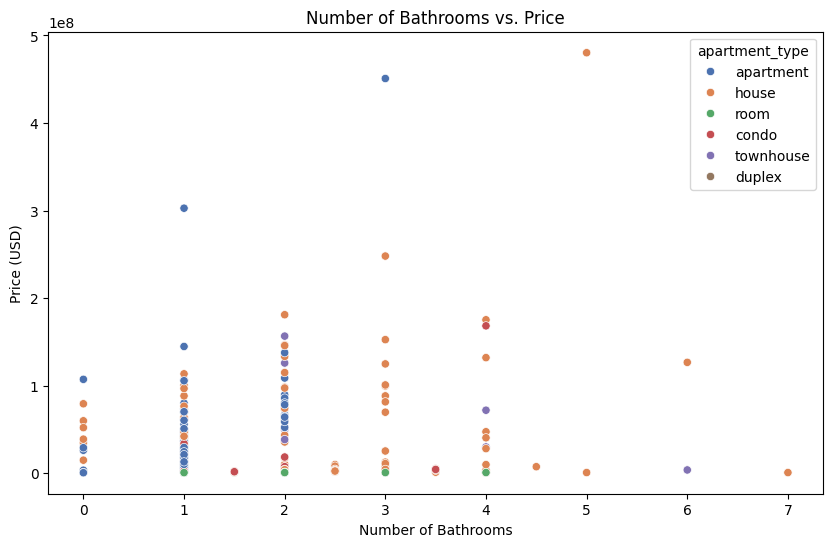

In [68]:
# Scatter Plot: Bathrooms vs. Price
plt.figure(figsize=(10,6))
sns.scatterplot(x='number_of_bathrooms', y='price', hue='apartment_type', data=df, palette='deep')
plt.title('Number of Bathrooms vs. Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price (USD)')
plt.show()


                     number_of_bedrooms  number_of_bathrooms
number_of_bedrooms             1.000000             0.644675
number_of_bathrooms            0.644675             1.000000


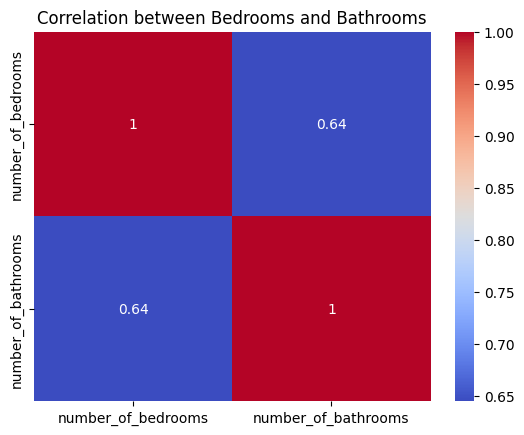

In [69]:

# Correlation between Bedrooms and Bathrooms
corr = df[['number_of_bedrooms', 'number_of_bathrooms']].corr()
print(corr)

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Bedrooms and Bathrooms')
plt.show()

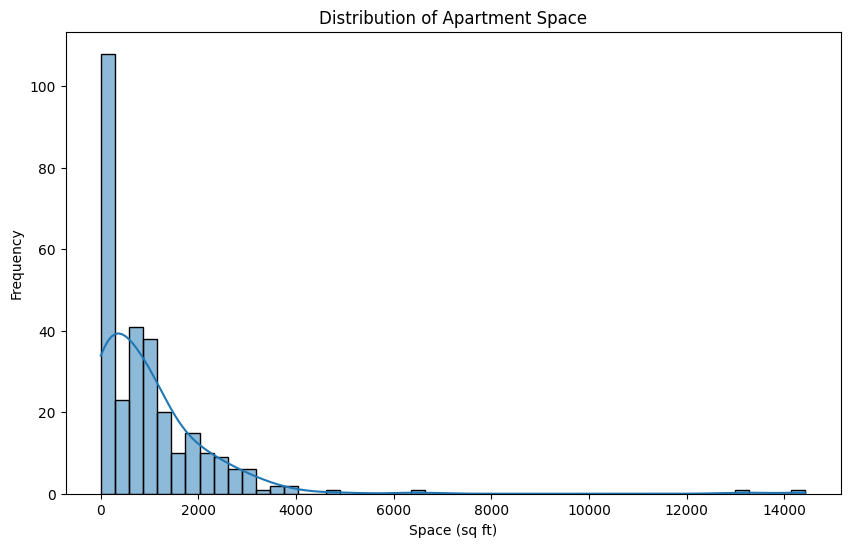

In [71]:
# Distribution of Space
plt.figure(figsize=(10,6))
sns.histplot(df['space'], bins=50, kde=True)
plt.title('Distribution of Apartment Space')
plt.xlabel('Space (sq ft)')
plt.ylabel('Frequency')
plt.show()



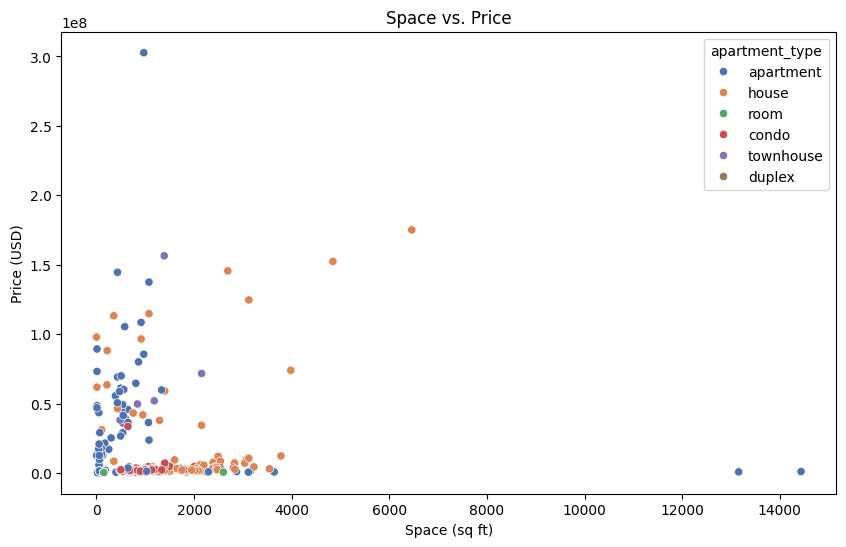

In [73]:
# Scatter Plot: Space vs. Price
plt.figure(figsize=(10,6))
sns.scatterplot(x='space', y='price', hue='apartment_type', data=df, palette='deep')
plt.title('Space vs. Price')
plt.xlabel('Space (sq ft)')
plt.ylabel('Price (USD)')
plt.show()



          space     price
space  1.000000  0.080498
price  0.080498  1.000000


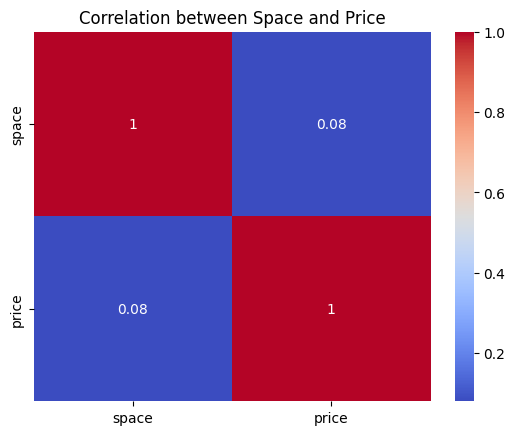

In [74]:
# Correlation between Space and Price
corr_space_price = df[['space', 'price']].corr()
print(corr_space_price)

sns.heatmap(corr_space_price, annot=True, cmap='coolwarm')
plt.title('Correlation between Space and Price')
plt.show()

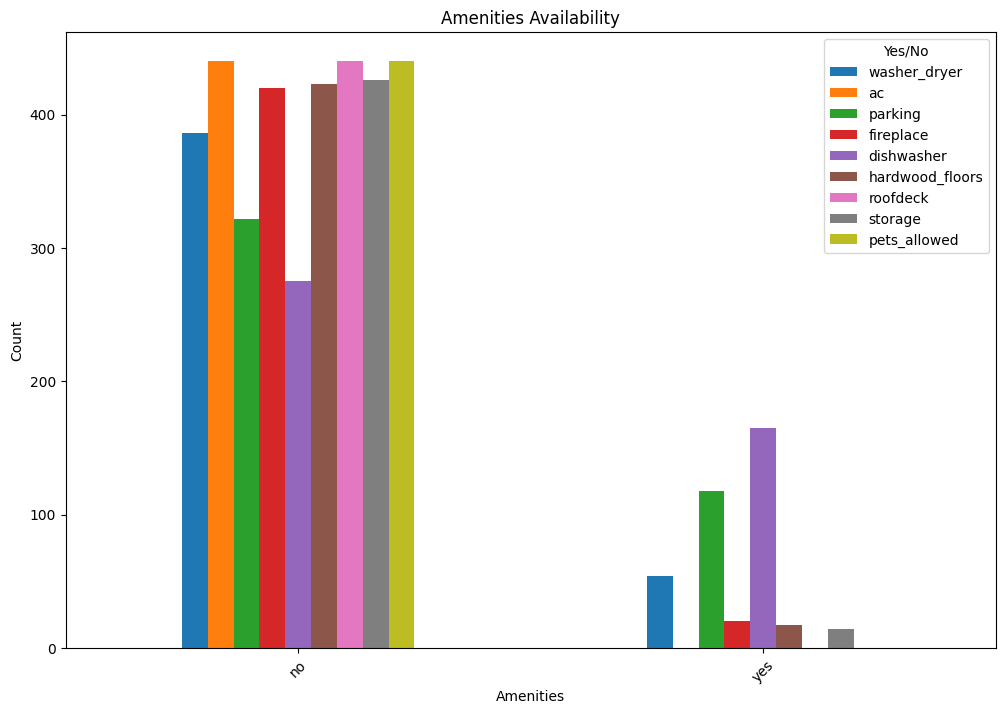

In [80]:
# List of amenities to analyze
amenities = ['washer_dryer', 'ac', 'parking', 'fireplace', 'dishwasher',
             'hardwood_floors', 'roofdeck', 'storage', 'pets_allowed']

# Calculate the frequency of each amenity
amenity_counts = df[amenities].apply(lambda x: x.value_counts()).fillna(0).astype(int)

# Plot the counts of amenities
amenity_counts.plot(kind='bar', figsize=(12,8))
plt.title('Amenities Availability')
plt.xlabel('Amenities')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Yes/No')
plt.show()



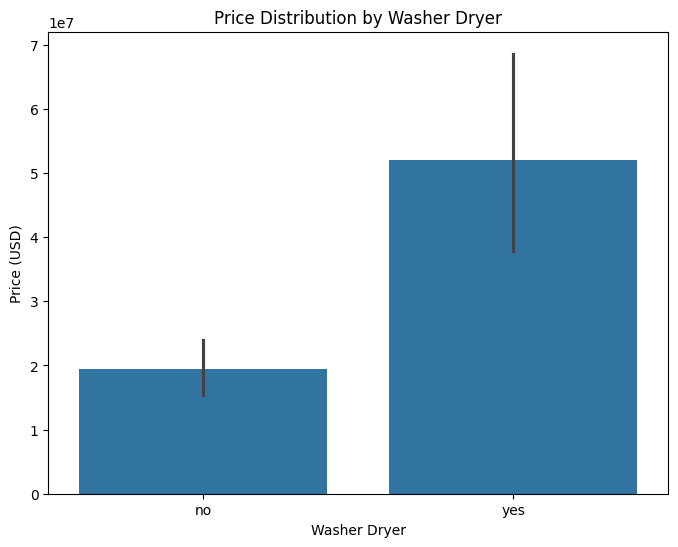

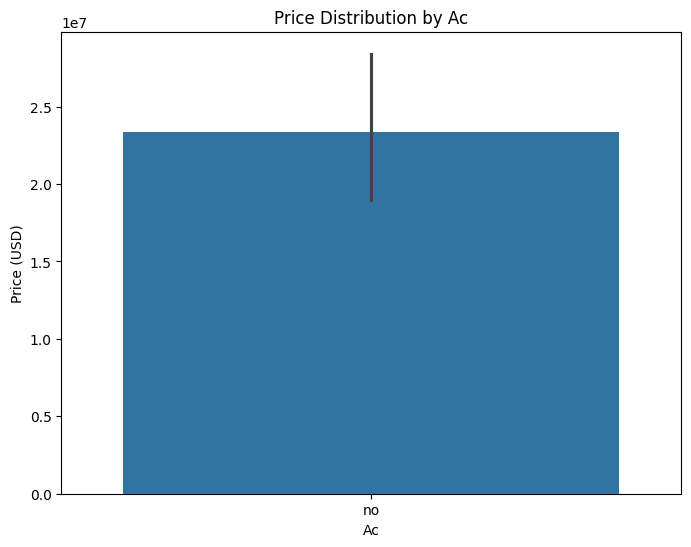

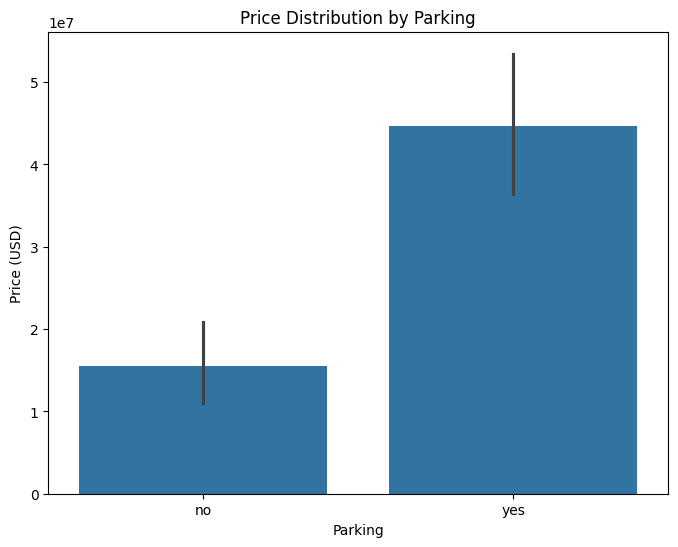

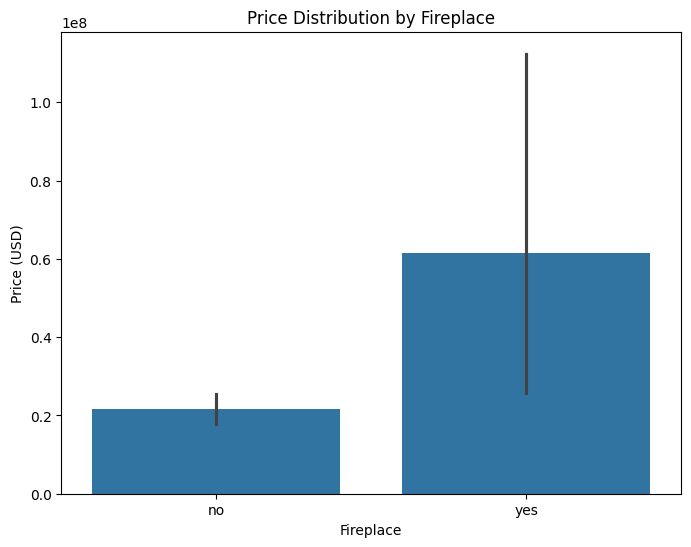

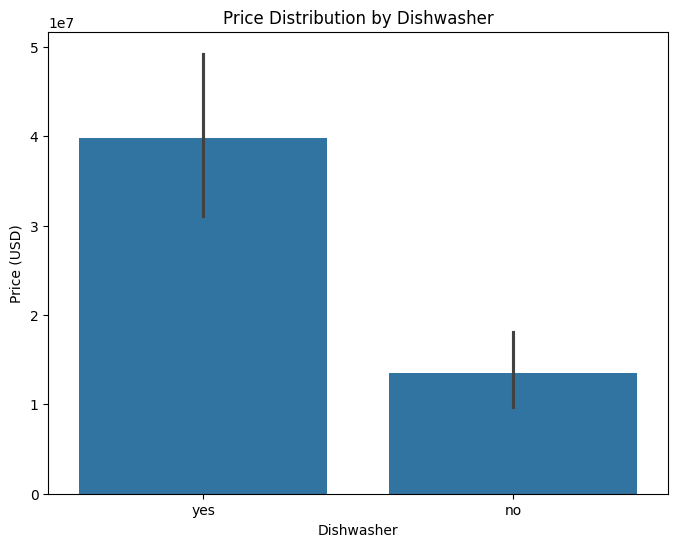

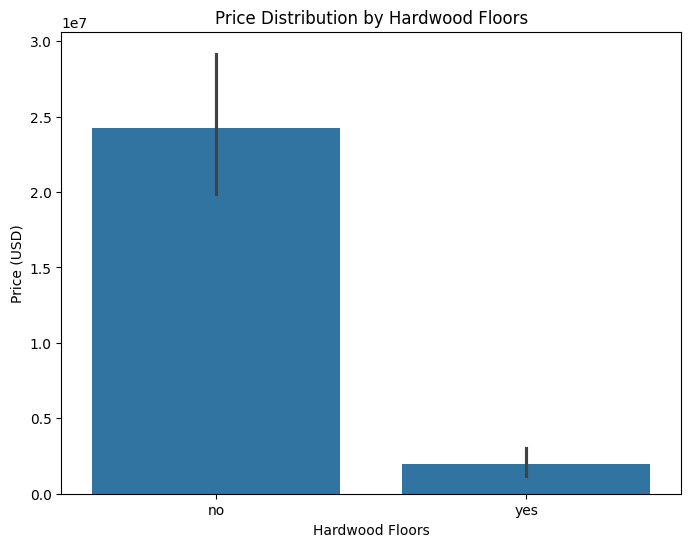

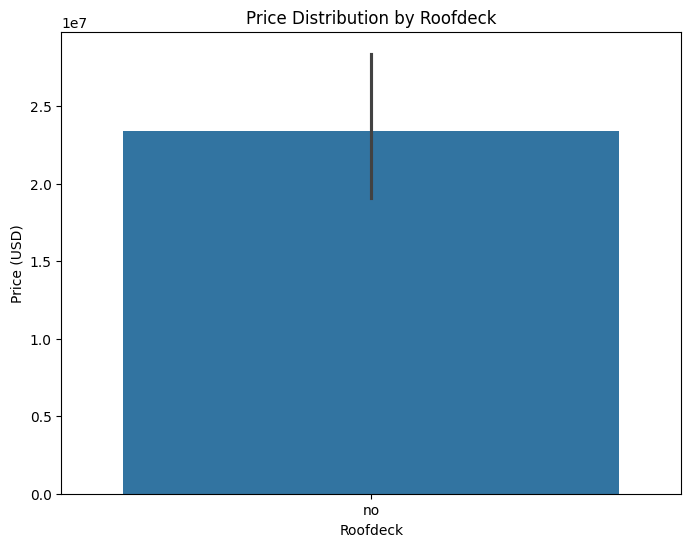

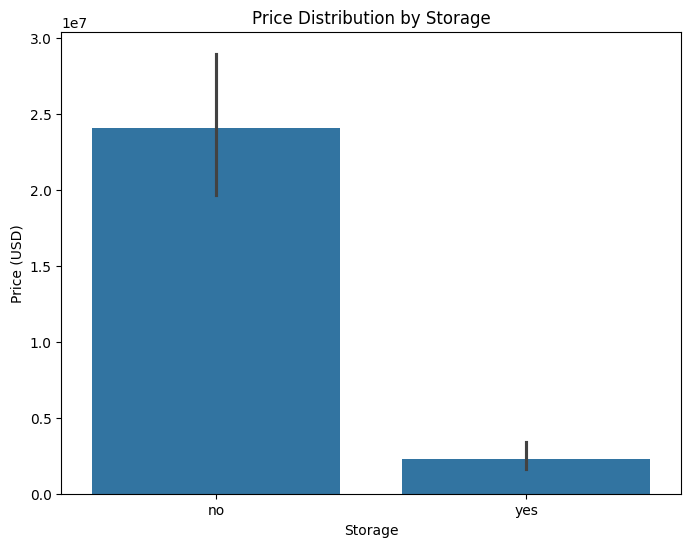

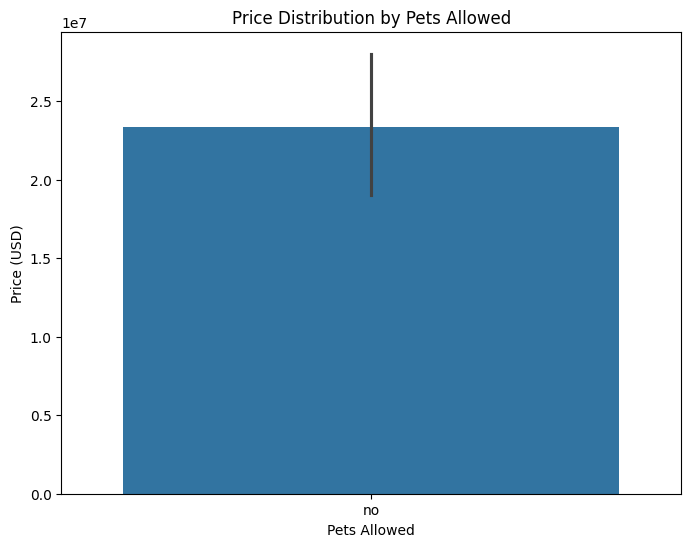

In [82]:
# Impact of Amenities on Price
for amenity in amenities:
    plt.figure(figsize=(8,6))
    sns.barplot(x=amenity, y='price', data=df)
    plt.title(f'Price Distribution by {amenity.replace("_", " ").title()}')
    plt.xlabel(amenity.replace("_", " ").title())
    plt.ylabel('Price (USD)')
    plt.show()

C:\Users\ve797\AppData\Local\Temp\ipykernel_36364\4191800028.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='apartment_type', y='price', data=avg_price_inr_type, palette='magma')


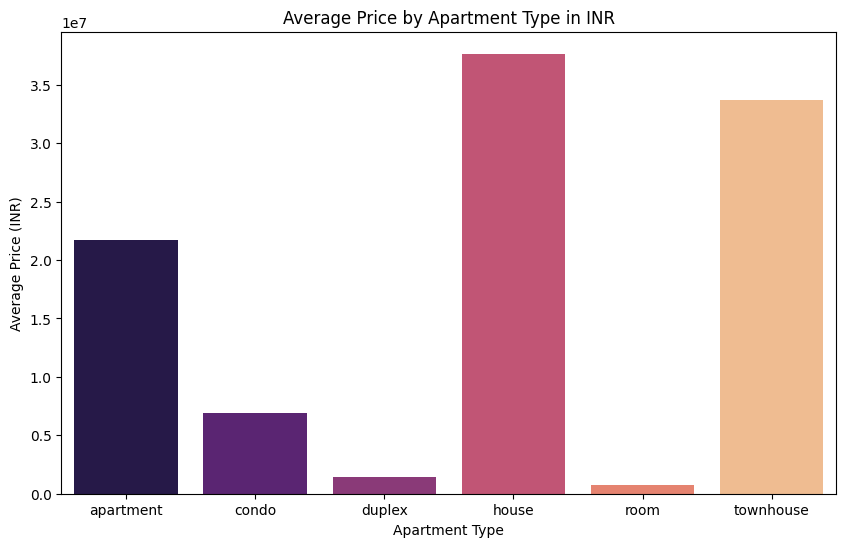

In [87]:

# Average Price in INR by Apartment Type
avg_price_inr_type = df.groupby('apartment_type')['price'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='apartment_type', y='price', data=avg_price_inr_type, palette='magma')
plt.title('Average Price by Apartment Type in INR')
plt.xlabel('Apartment Type')
plt.ylabel('Average Price (INR)')
plt.show()

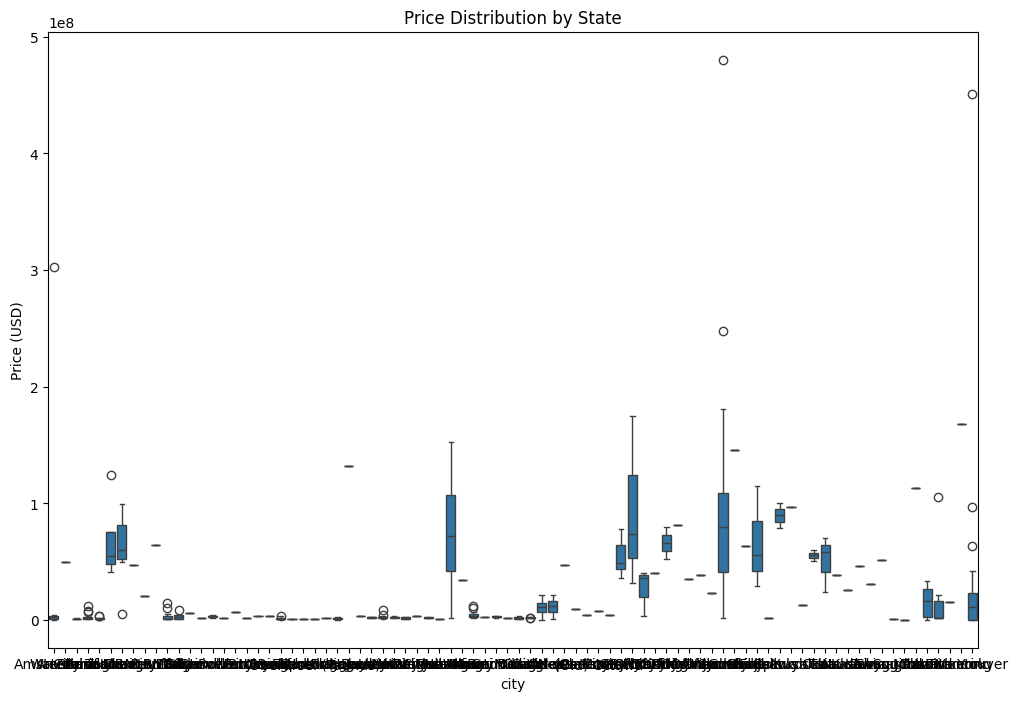

In [98]:
# Regional price distribution by state
plt.figure(figsize=(12,8))
sns.boxplot(x='city', y='price', data=df)
plt.title('Price Distribution by State')
plt.xlabel('city')
plt.ylabel('Price (USD)')
plt.show()



C:\Users\ve797\AppData\Local\Temp\ipykernel_36364\3025887047.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='longitude', y='latitude', data=df, cmap='Reds', shade=True, thresh=0.05)


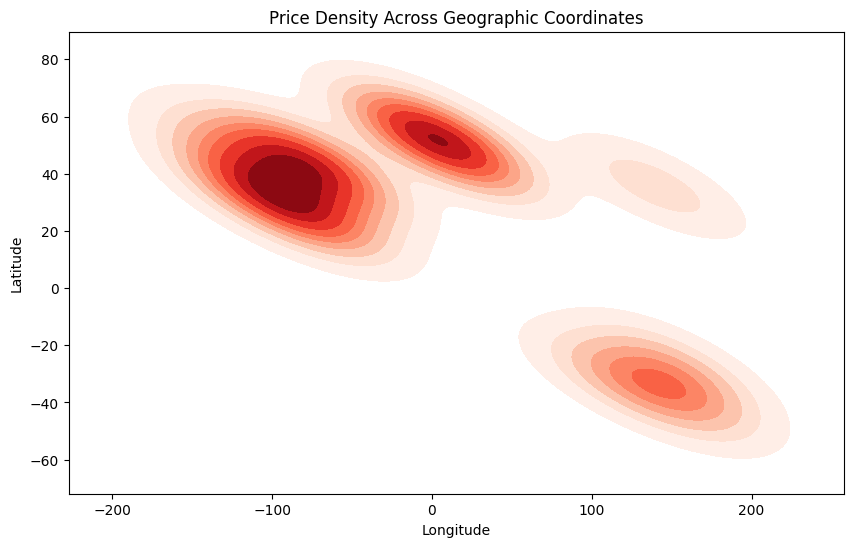

In [99]:

# Heatmap of price density across geographic coordinates
plt.figure(figsize=(10,6))
sns.kdeplot(x='longitude', y='latitude', data=df, cmap='Reds', shade=True, thresh=0.05)
plt.title('Price Density Across Geographic Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()




C:\Users\ve797\AppData\Local\Temp\ipykernel_36364\1589281929.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price', y='city', data=avg_price_city.sort_values('price', ascending=False), palette='coolwarm')


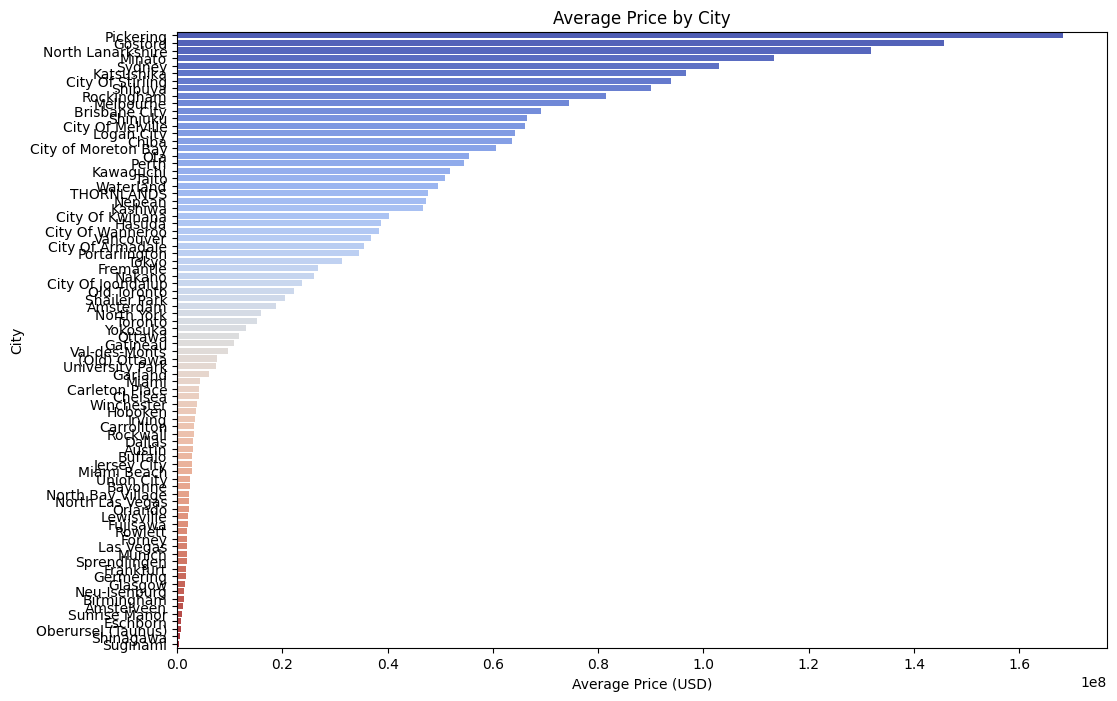

In [100]:
# Average Price by City
avg_price_city = df.groupby('city')['price'].mean().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='price', y='city', data=avg_price_city.sort_values('price', ascending=False), palette='coolwarm')
plt.title('Average Price by City')
plt.xlabel('Average Price (USD)')
plt.ylabel('City')
plt.show()


                        price  number_of_bedrooms  number_of_bathrooms  \
price                1.000000            0.083984             0.214944   
number_of_bedrooms   0.083984            1.000000             0.644675   
number_of_bathrooms  0.214944            0.644675             1.000000   
space                0.080498            0.239980             0.391096   
latitude            -0.487743            0.010192            -0.112318   
longitude            0.473292           -0.107771            -0.110486   
deposit              0.540827            0.105033             0.182540   
price                1.000000            0.083984             0.214944   

                        space  latitude  longitude   deposit     price  
price                0.080498 -0.487743   0.473292  0.540827  1.000000  
number_of_bedrooms   0.239980  0.010192  -0.107771  0.105033  0.083984  
number_of_bathrooms  0.391096 -0.112318  -0.110486  0.182540  0.214944  
space                1.000000 -0.122003  

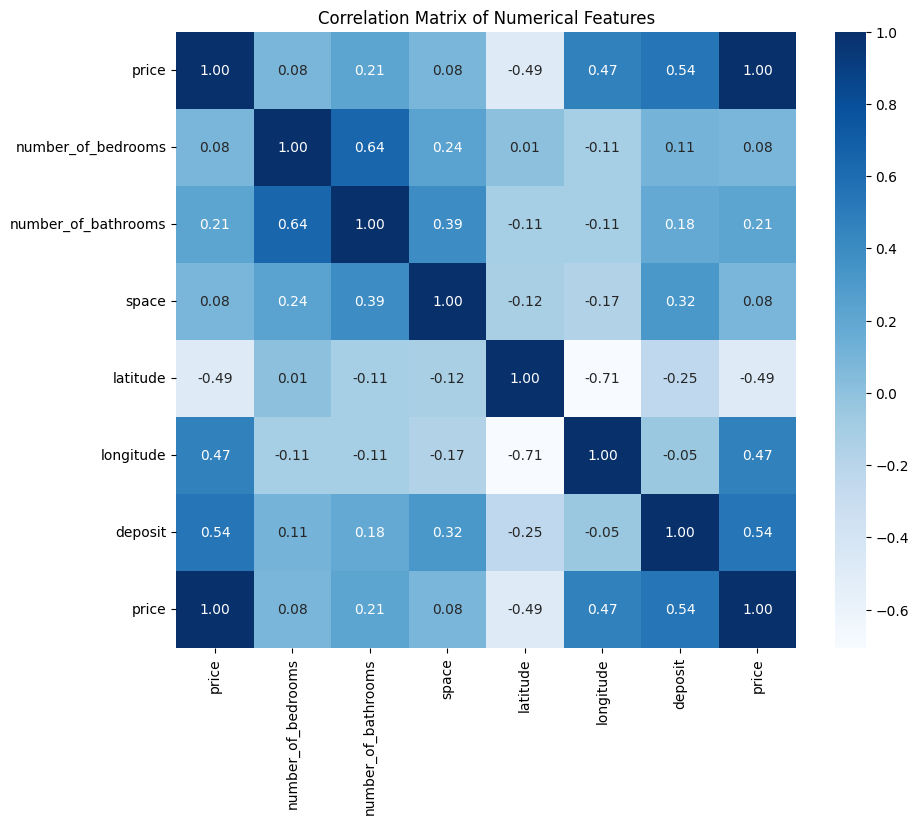

In [102]:
# Calculate correlation matrix for numerical features
numerical_features = ['price', 'number_of_bedrooms', 'number_of_bathrooms', 'space', 'latitude', 'longitude', 'deposit', 'price']
corr_matrix = df[numerical_features].corr()

# Display correlation matrix
print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

C:\Users\ve797\AppData\Local\Temp\ipykernel_36364\3222914206.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_listings = df.resample('M').size()


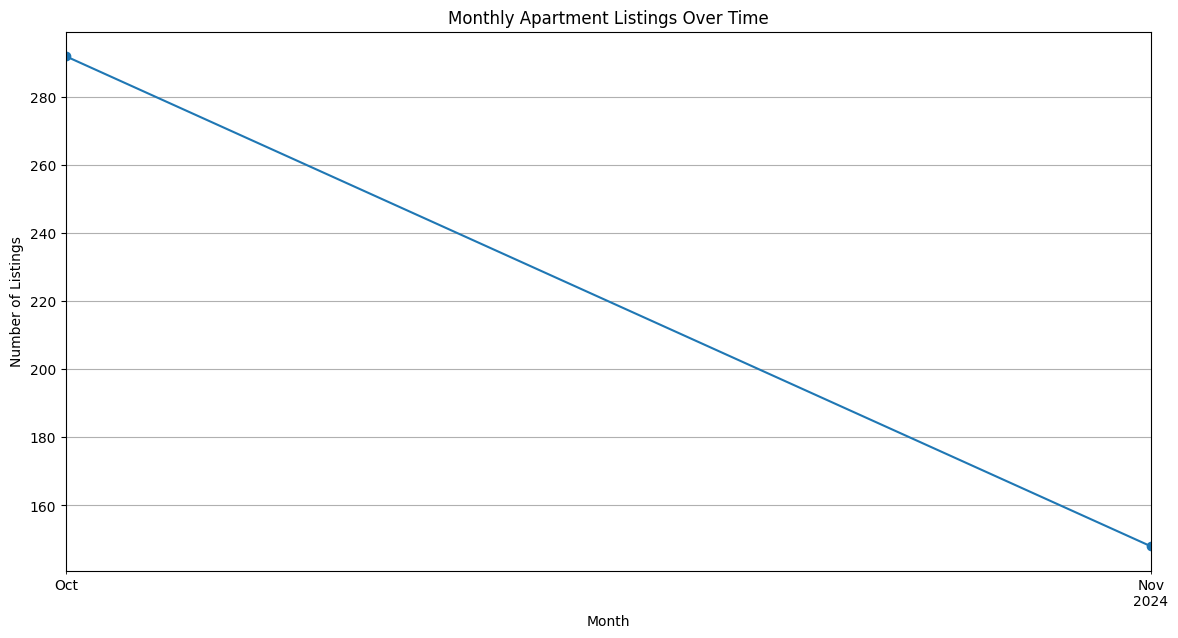

In [104]:
# Convert 'listed_at' to datetime if not already done
df['listed_at'] = pd.to_datetime(df['listed_at'], errors='coerce')

# Set 'listed_at' as the DataFrame index
df.set_index('listed_at', inplace=True)

# Resample data monthly and count listings
monthly_listings = df.resample('M').size()

# Plot time-series of listings
plt.figure(figsize=(14,7))
monthly_listings.plot(marker='o', linestyle='-')
plt.title('Monthly Apartment Listings Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Listings')
plt.grid(True)
plt.show()

# Reset index for further analysis
df.reset_index(inplace=True)


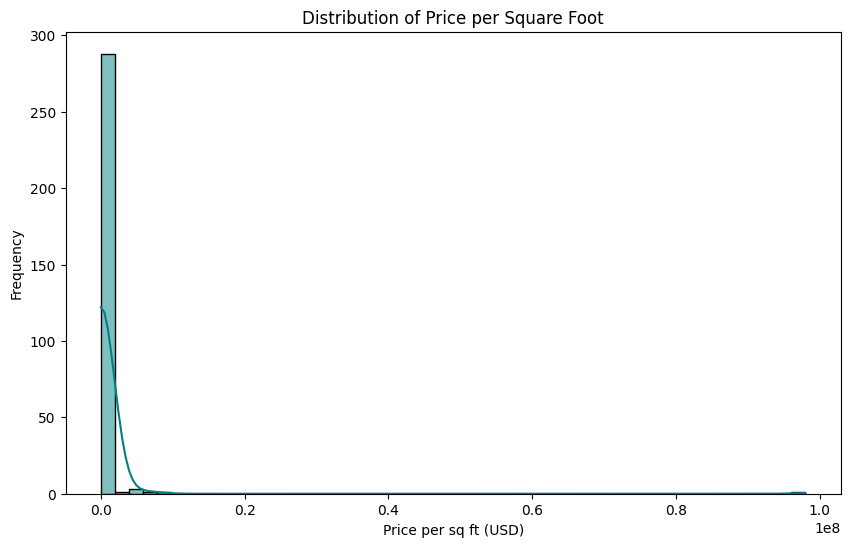

In [106]:
# Calculate price per square foot
df['price_per_sqft'] = df['price'] / df['space']

# Distribution of Price per Square Foot
plt.figure(figsize=(10,6))
sns.histplot(df['price_per_sqft'], bins=50, kde=True, color='teal')
plt.title('Distribution of Price per Square Foot')
plt.xlabel('Price per sq ft (USD)')
plt.ylabel('Frequency')
plt.show()



C:\Users\ve797\AppData\Local\Temp\ipykernel_36364\2505866260.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='apartment_type', y='price_per_sqft', data=avg_ppsqft, palette='pastel')


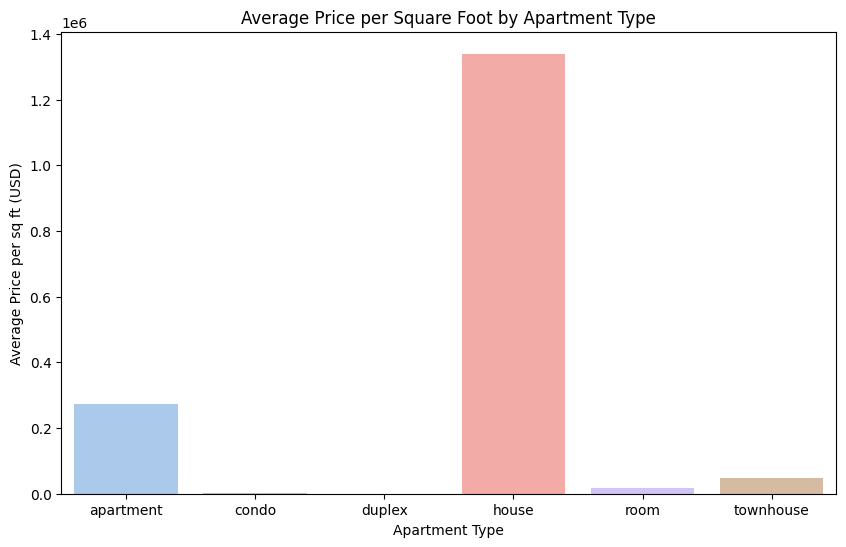

In [107]:
# Average Price per Square Foot by Apartment Type
avg_ppsqft = df.groupby('apartment_type')['price_per_sqft'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='apartment_type', y='price_per_sqft', data=avg_ppsqft, palette='pastel')
plt.title('Average Price per Square Foot by Apartment Type')
plt.xlabel('Apartment Type')
plt.ylabel('Average Price per sq ft (USD)')
plt.show()


Pricing Patterns:

Apartment prices are positively correlated with the number of bedrooms, bathrooms, and overall space.
Certain apartment types, such as houses, command higher prices compared to rooms or smaller apartments.

Geographic Trends:

Listings are concentrated in specific neighborhoods, with prices varying significantly across different regions.
Proximity to amenities like universities, business districts, and transportation hubs influences pricing.
Amenity Impact:

Amenities like AC, parking, and hardwood floors are strongly associated with higher apartment prices.
Apartments allowing pets attract a broader tenant base, potentially increasing demand.

Temporal Dynamics:

Listing volumes fluctuate seasonally, with peaks during warmer months, aligning with typical moving seasons.
Time to availability varies by apartment type, indicating differences in market demand.

Value Assessment:

Price per square foot offers a standardized metric to compare value across different apartment sizes and types.
Apartments with lower price per square foot provide better value for renters.

Currency Conversion:

Converting prices to INR facilitates international market comparisons, revealing affordability from a different economic perspective.

### Phase 4